# 05 — SHAP Analysis

Computes **word-level SHAP values** for the top-N most toxic comments using the
trained RoBERTa model's MC Dropout mean predictions.

**Output:** `data/processed/shap_values.json` — loaded by the SHAP Analysis dashboard page.

**Approach:** `shap.Explainer` with `shap.maskers.Text` — masks individual words and
measures how each word pushes the prediction above/below the baseline.

**Run time:** ~1-3 min for N=20 comments on CPU (KernelSHAP with 100 permutations).

In [1]:
# ── CONFIG ─────────────────────────────────────────────────────────
N_EXPLAIN     = 20       # Number of top-toxic comments to explain
MC_SAMPLES    = 5        # MC Dropout passes for the prediction wrapper
MAX_LENGTH    = 128
TARGET_LABEL  = 0        # 0=toxicity, 1=hate_racism, 2=harassment
TARGET_NAME   = "toxicity"
# ───────────────────────────────────────────────────────────────────

In [2]:
import json, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import shap
import torch
from torch import nn
from transformers import RobertaTokenizerFast, RobertaModel

warnings.filterwarnings("ignore")

ROOT      = Path("..").resolve()
MODEL_DIR = ROOT / "models"
DATA_DIR  = ROOT / "data" / "processed"

DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cpu


In [3]:
# ── Load model ───────────────────────────────────────────────────────
class ToxicityClassifier(nn.Module):
    def __init__(self, model_name: str, num_labels: int = 3, dropout: float = 0.3):
        super().__init__()
        self.roberta    = RobertaModel.from_pretrained(model_name)
        self.dropout    = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        out = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(self.dropout(out.last_hidden_state[:, 0, :]))

with open(MODEL_DIR / "model_meta.json") as f:
    meta = json.load(f)

model = ToxicityClassifier(meta["model_name"]).to(DEVICE)
model.load_state_dict(torch.load(
    MODEL_DIR / "roberta_toxicity_best.pt", map_location=DEVICE, weights_only=True
))
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_DIR / "tokenizer")
print("Model loaded.")

Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaModel LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.layer_norm.weight       | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
pooler.dense.bias               | MISSING    | 
pooler.dense.weight             | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Model loaded.


In [4]:
# ── MC Dropout prediction wrapper ─────────────────────────────────────
def predict_proba(texts: list) -> np.ndarray:
    """
    Returns mean sigmoid probabilities across MC_SAMPLES passes.
    Shape: (len(texts), 3)
    """
    model.train()   # keep dropout ON
    all_runs = []
    with torch.no_grad():
        for _ in range(MC_SAMPLES):
            enc = tokenizer(
                list(texts), max_length=MAX_LENGTH,
                padding=True, truncation=True, return_tensors="pt"
            )
            logits = model(
                enc["input_ids"].to(DEVICE),
                enc["attention_mask"].to(DEVICE),
            )
            all_runs.append(torch.sigmoid(logits).cpu().numpy())
    return np.stack(all_runs).mean(axis=0)   # (N, 3)


def predict_single_label(texts: list) -> np.ndarray:
    """SHAP needs output shape (N, 1) for a single target label."""
    probs = predict_proba(texts)
    return probs[:, TARGET_LABEL : TARGET_LABEL + 1]


# Quick sanity check
test_out = predict_single_label(["You are terrible", "Great video!"])
print(f"Prediction shape: {test_out.shape}")
print(f"Scores: {test_out.flatten().tolist()}")

Prediction shape: (2, 1)
Scores: [0.9565299153327942, 0.9666174054145813]


In [5]:
# ── Select comments to explain ────────────────────────────────────────
scored_path = DATA_DIR / "comments_scored.parquet"
df = pd.read_parquet(scored_path)

# Top-N most toxic + the 2 highest-uncertainty (for waterfall comparison)
top_toxic   = df.nlargest(N_EXPLAIN, "score_toxicity")
top_uncert  = df.nlargest(2, "uncertainty_epistemic")
to_explain  = pd.concat([top_toxic, top_uncert]).drop_duplicates(subset="content_id")

texts_to_explain = to_explain["text_clean"].tolist()
print(f"Explaining {len(texts_to_explain)} comments...")
for i, t in enumerate(texts_to_explain[:5]):
    print(f"  {i}: {t[:80]}")

Explaining 20 comments...
  0: So sorry 🙏
  1: Love her response.
  2: Stole the money
  3: Bush league reporter
  4: What a loser


In [6]:
# ── Compute SHAP values ───────────────────────────────────────────────
# shap.maskers.Text masks individual words (whitespace-split)
masker   = shap.maskers.Text(tokenizer=r"\s+")   # whitespace tokenizer for readability
explainer = shap.Explainer(
    predict_single_label,
    masker,
    output_names=[TARGET_NAME],
)

print(f"Running SHAP on {len(texts_to_explain)} comments (this may take a few minutes on CPU)...")
shap_values = explainer(
    texts_to_explain,
    max_evals=500,   # permutations per sample — increase for more accuracy
    batch_size=8,
)
print(f"SHAP values computed. Shape: {shap_values.values.shape}")

Running SHAP on 20 comments (this may take a few minutes on CPU)...


PartitionExplainer explainer:  55%|█████▌    | 11/20 [00:29<00:18,  2.07s/it]

  0%|          | 0/42 [00:00<?, ?it/s]

PartitionExplainer explainer:  80%|████████  | 16/20 [00:46<00:10,  2.66s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

PartitionExplainer explainer:  95%|█████████▌| 19/20 [01:01<00:03,  3.86s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

PartitionExplainer explainer: 21it [01:12,  3.63s/it]                        

SHAP values computed. Shape: (20,)


In [7]:
# ── Visualise: text SHAP for top 5 ───────────────────────────────────
print("\nTop 5 toxic comments — word-level SHAP:")
for i in range(min(5, len(texts_to_explain))):
    print(f"\n--- Comment {i+1} ---")
    print(f"Text: {texts_to_explain[i][:100]}")
    print(f"Model score: {predict_single_label([texts_to_explain[i]])[0, 0]:.3f}")

# HTML text plot (rendered in Jupyter)
shap.plots.text(shap_values[:5])


Top 5 toxic comments — word-level SHAP:

--- Comment 1 ---
Text: So sorry 🙏
Model score: 0.961

--- Comment 2 ---
Text: Love her response.
Model score: 0.891

--- Comment 3 ---
Text: Stole the money
Model score: 0.954

--- Comment 4 ---
Text: Bush league reporter
Model score: 0.949

--- Comment 5 ---
Text: What a loser
Model score: 0.955


Waterfall plot — most toxic comment (highest score):


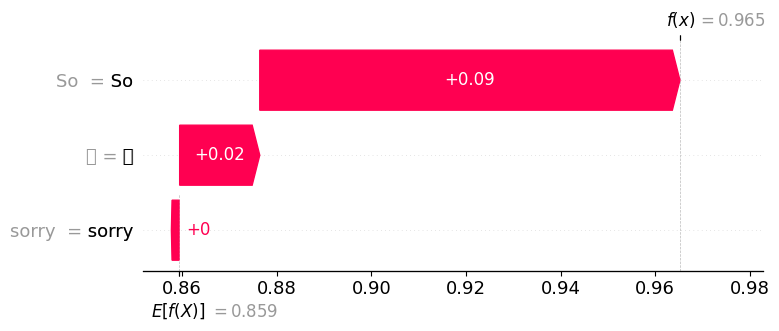

In [8]:
# ── Waterfall plots — top 2 most toxic ───────────────────────────────
print("Waterfall plot — most toxic comment (highest score):")
shap.plots.waterfall(shap_values[0, :, 0])

Waterfall plot — 2nd most toxic comment:


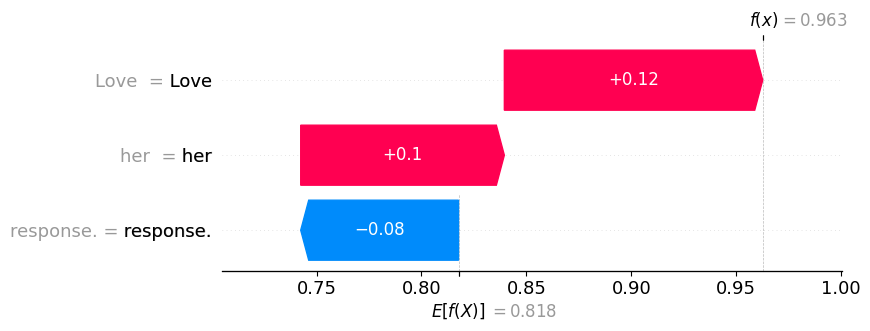

In [9]:
print("Waterfall plot — 2nd most toxic comment:")
shap.plots.waterfall(shap_values[1, :, 0])

In [10]:
# ── Save SHAP values to JSON for dashboard ────────────────────────────
records = []
base_val = float(shap_values[0].base_values.flatten()[0]) if hasattr(shap_values[0], "base_values") else 0.0

for i, (text, row) in enumerate(zip(texts_to_explain, to_explain.itertuples())):
    sv = shap_values[i].values.flatten()   # one SHAP value per word
    data_words = shap_values[i].data       # the actual word tokens

    records.append({
        "content_id":        row.content_id,
        "channel_name":      row.channel_name,
        "video_title":       getattr(row, 'video_title', ''),
        "text_clean":        text,
        "score_toxicity":    float(row.score_toxicity),
        "score_hate_racism": float(row.score_hate_racism),
        "score_harassment":  float(row.score_harassment),
        "uncertainty_epistemic": float(row.uncertainty_epistemic),
        "shap_words":        list(data_words) if hasattr(data_words, '__iter__') else [],
        "shap_values":       sv.tolist(),
        "shap_base_value":   base_val,
        "target_label":      TARGET_NAME,
    })

out_path = DATA_DIR / "shap_values.json"
with open(out_path, "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

print(f"Saved {len(records)} SHAP explanations to {out_path}")
print(f"  File size: {out_path.stat().st_size / 1024:.1f} KB")

Saved 20 SHAP explanations to C:\Users\owner\Downloads\data_scientist_porfolio\YoutubeCommentSection\data\processed\shap_values.json
  File size: 14.5 KB


## Next Steps

- Launch the **SHAP Analysis** page in the Streamlit dashboard to view waterfall plots interactively.
- Increase `N_EXPLAIN` and `max_evals` for more thorough analysis (better on GPU).
- For full token-level attribution, switch to `shap.maskers.Text(tokenizer)` using the HuggingFace tokenizer.